In [1]:
# Importacion de librerias necesarias para el proyecto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [1], organizaste bien las importaciones y usaste alias estándar (<code>pd</code>, <code>plt</code>, <code>sns</code>, <code>np</code>, <code>st</code>). Esto facilita la lectura y evita confusiones. Ese orden al inicio ayuda a cualquier persona a correr el notebook sin adivinar dependencias. Mantén esta práctica: suma claridad y reduce errores por nombres inconsistentes.
</div>

# Limpieza y preparacion de datos para el análisis

In [2]:
hipotesis= pd.read_csv("/datasets/hypotheses_us.csv", sep=";")
pedidos= pd.read_csv("/datasets/orders_us.csv")
visitas= pd.read_csv("/datasets/visits_us.csv")


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [2], cargaste archivos con el separador correcto para <code>hypotheses_us.csv</code> y dejaste los demás con el valor por defecto. Esta precisión muestra que verificaste el formato de cada fuente antes de leerla. Esto evita columnas pegadas o tipos mal detectados y garantiza que los datos lleguen limpios al análisis.
</div>

In [3]:
hipotesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
pedidos['transactionId']=pedidos['transactionId'].astype(str)
pedidos['visitorId']=pedidos['visitorId'].astype(str)
pedidos['date']=pd.to_datetime(pedidos['date'])
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   object        
 1   visitorId      1197 non-null   object        
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 46.9+ KB


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
Buena decisión en la celda [4] al convertir <code>transactionId</code> y <code>visitorId</code> a texto y <code>date</code> a fecha. Esto previene errores al agrupar/contar por identificadores (que no deben sumarse) y permite operaciones temporales sólidas. Con <code>info()</code> confirmaste el cambio, lo cual cierra el ciclo de validación de tipos de manera ordenada.
</div>

In [5]:
# Encontrar visitantes que están en ambos grupos
visitantes_por_grupo = pedidos.groupby('visitorId')['group'].nunique()
visitantes_problematicos = visitantes_por_grupo[visitantes_por_grupo > 1].index
print(f"Visitantes en ambos grupos: {len(visitantes_problematicos)}")

Visitantes en ambos grupos: 58


In [6]:
# Eliminar visitantes problemáticos
if len(visitantes_problematicos) > 0:
    pedidos = pedidos[~pedidos['visitorId'].isin(visitantes_problematicos)]
    print(f"Se eliminaron {len(visitantes_problematicos)} visitantes problemáticos")

Se eliminaron 58 visitantes problemáticos


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En las celdas [5]-[6] detectaste y excluiste visitantes presentes en ambos grupos. Esta limpieza es clave para un test A/B, porque evita contaminación de grupos y sesgos en las métricas. Además, reportaste cuántos visitantes se eliminaron, lo que aporta transparencia y reproducibilidad al proceso.
</div>

In [7]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   object        
 1   visitorId      1016 non-null   object        
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 47.6+ KB


In [8]:
visitas['date']=pd.to_datetime(visitas['date'])
visitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [8], parseaste la fecha en <code>visitas</code> y verificaste con <code>info()</code>. Esto te habilita a hacer uniones y gráficos temporales sin fricciones. Es una de esas pequeñas cosas que evitan muchos dolores de cabeza más adelante. Bien visto.
</div>

# Parte 1. Priorizar hipótesis

In [9]:
hipotesis

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [10]:
# Se calculo el framework ICE para cada hipotesis
hipotesis['ICE']=(hipotesis['Impact']*hipotesis['Confidence'])/hipotesis['Effort']

print(hipotesis[['Hypothesis','ICE']].sort_values(by='ICE',ascending=False))

                                          Hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


In [11]:
# Se calculo el framework RICE para cada hipotesis
hipotesis['RICE']=(hipotesis['Reach']*hipotesis['Impact']*hipotesis['Confidence'])/hipotesis['Effort']

print(hipotesis[['Hypothesis','RICE']].sort_values(by='RICE',ascending=False))

                                          Hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


In [12]:
print(hipotesis[['Hypothesis','ICE','RICE']].sort_values(by='RICE',ascending=False))

                                          Hypothesis        ICE   RICE
7  Add a subscription form to all the main pages....  11.200000  112.0
2  Add product recommendation blocks to the store...   7.000000   56.0
0  Add two new channels for attracting traffic. T...  13.333333   40.0
6  Show banners with current offers and sales on ...   8.000000   40.0
8  Launch a promotion that gives users discounts ...  16.200000   16.2
3  Change the category structure. This will incre...   1.125000    9.0
1  Launch your own delivery service. This will sh...   2.000000    4.0
5  Add a customer review page. This will increase...   1.333333    4.0
4  Change the background color on the main page. ...   1.000000    3.0


<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la comparación ICE vs RICE (celdas [10]-[12]) la conclusión dice que “RICE es más confiable” por incluir Reach. Es una buena intuición, pero conviene matizar: RICE es más adecuado cuando el alcance (Reach) es un factor crítico del negocio; si Reach es incierto o estimado con ruido, puede distorsionar la priorización. Una alternativa práctica es analizar ambos rankings y justificar con contexto (p. ej., madurez del canal, facilidad de implementación) por qué elegir uno. Así, la priorización queda mejor respaldada por negocio y datos.
</div>

**CONCLUSION**

Podemos observar que hay mucha diferencia entre cada framework para algunas hipotesis, esto se debe que para el framework RICE se considera el parametro Reach. Para las hipotesis que no cambio mucho su puntaje, su valor de Reach es bajo y para los que si cambio mucho, su valor de Reach fue alto.

El framework RICE es mas confiable ya que considera todos los parametros del ICE y ademas el parametro Reach.

# Parte 2. Análisis del test A/B

In [13]:
pedidos

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
La exploración directa de <code>pedidos</code> y <code>visitas</code> en las celdas [13]-[14] ayuda a validar que las transformaciones previas se reflejen en las tablas. Es un paso simple, pero muy eficiente para detectar valores que “no cuadran” antes de extraer métricas. Buen hábito de inspección rápida.
</div>

In [14]:
visitas

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


**1. Representa gráficamente el ingreso acumulado por grupo.**

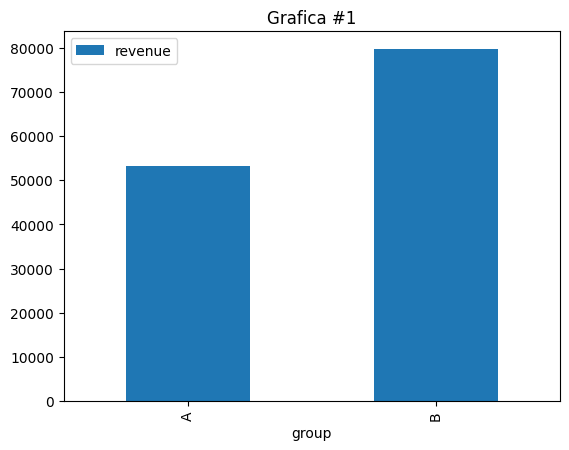

In [15]:
pedidos.groupby('group').agg({'revenue': 'sum'}).plot(kind='bar', title='Grafica #1')
plt.show()


**Conclusion:**

Se pude observar en el grafico que hay un aumento de ingresos, por lo que se puede decir hasta el momento que la prueba A/B si funciono


**2. Representa gráficamente el tamaño de pedido promedio acumulado por grupo.**

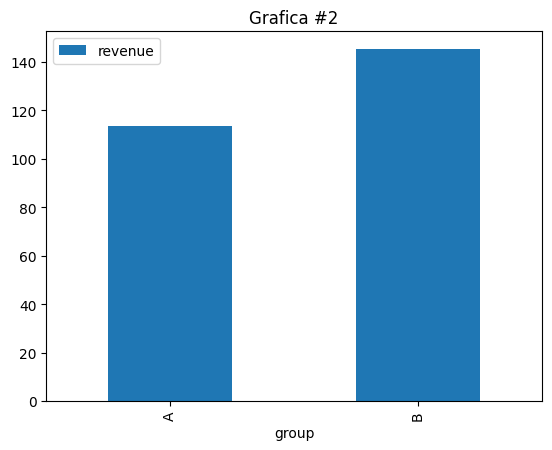

In [16]:
pedidos.groupby('group').agg({'revenue': 'mean'}).plot(kind='bar', title='Grafica #2')
plt.show()


**Conclusion:**

Mismo caso que la grafica #1, hubo un aumento en el tamaño de pedido promedio, por lo que se ve la prueba va en buen camino.



**3. Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.**

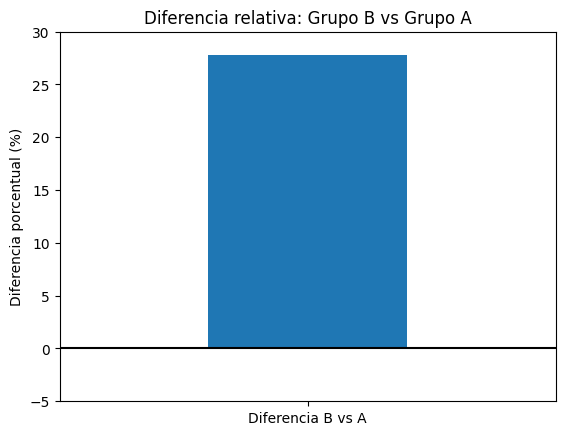

In [17]:
tamaño_promedio = pedidos.groupby('group')['revenue'].mean()

diferencia_relativa = (tamaño_promedio['B'] - tamaño_promedio['A']) / tamaño_promedio['A'] * 100

plt.bar(['Diferencia B vs A'], [diferencia_relativa])
plt.title('Diferencia relativa: Grupo B vs Grupo A')
plt.ylabel('Diferencia porcentual (%)')
plt.axhline(y=0, color='black', linestyle='-')
plt.ylim([-5, 30])
plt.xlim([-1,1])
plt.show()

<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [17], la “diferencia relativa acumulada” se calculó como una sola barra a partir de medias globales. Para responder a la consigna, conviene calcular la diferencia relativa a lo largo del tiempo sobre promedios acumulados diarios: <code>(AOV_B_cum - AOV_A_cum)/AOV_A_cum</code>. Eso permite ver si la ventaja de B es consistente o depende de algunos días. Además, ajustar el eje Y a los valores reales evita cortes artificiales y mejora la lectura.
</div>



**Conclusion:**

Como se puede ver en la grafica anterior la diferencia entre el grupo A y el grupo B es mas de 25% (para ser exactos 27.8%), todavia falta comprobar la hipotesis si esta diferencia es realmente significativa para aprobarla como exito.



**4. Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia.**

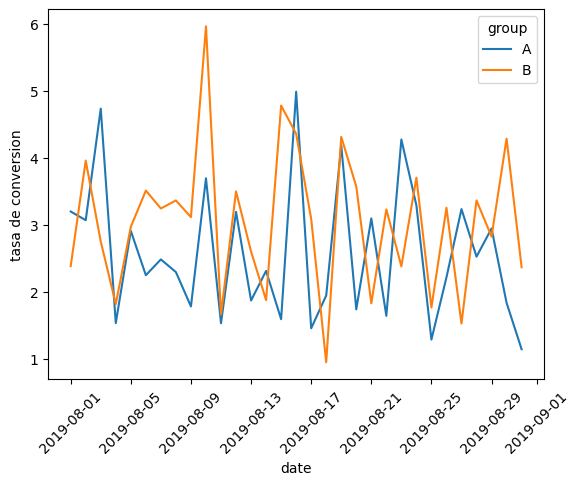

In [18]:

pedidos_por_dia = pedidos.groupby(['date', 'group'])['visitorId'].count()
pedidos_por_dia = pedidos_por_dia.reset_index()
pedidos_por_dia.columns = ['date', 'group', 'pedidos']
relacion_pedidos_visitas = visitas.merge(pedidos_por_dia, on=['date', 'group'], how='left')

relacion_pedidos_visitas['tasa de conversion']= (relacion_pedidos_visitas['pedidos']/relacion_pedidos_visitas['visits'])*100

sns.lineplot(x='date', y='tasa de conversion', data=relacion_pedidos_visitas, hue='group')
plt.xticks(rotation=45)
plt.show()



<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
En la celda [18], la tasa de conversión se calculó como <code>pedidos/visitas</code> por día. Esto es válido si usamos pedidos como aproximación a compradores, pero cuando un usuario puede hacer más de un pedido, esa métrica tiende a inflarse. Para una conversión más alineada con “visitante → comprador”, conviene usar compradores únicos por día: <code>nunique(visitorId)</code> en lugar de <code>count</code>. También es útil rellenar ausencias con 0 pedidos para no perder días en el gráfico y, si hay mucha variación diaria, usar un promedio móvil para suavizar y comparar mejor.
</div>


**Conclusion:**

Se puede observar en la grafica anterior que el rendimiento de los dos grupos varia mucho, hay dias que es mejor el grupo A y otros dias es mejor el grupo B, pero se puede identificar dos anomalias desde el 2019-08-05 al 2019-08-10 es muy superior el grupo B y tambien desde el dia  2019-08-29 el grupo B supera por mucho al grupo A.



**5. Traza un gráfico de dispersión del número de pedidos por usuario.**

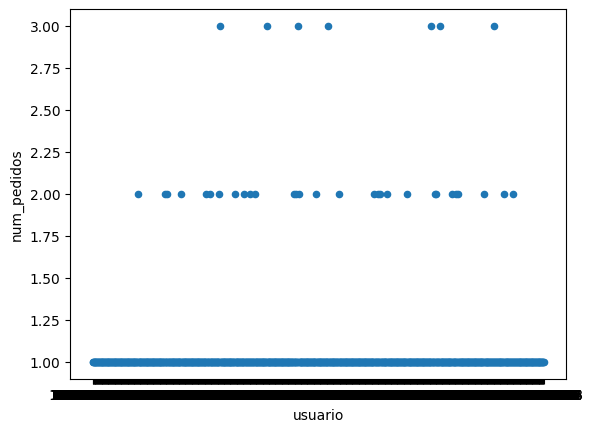

In [19]:
pedidos_por_usuario = pedidos.groupby('visitorId').agg({'transactionId':'count'}).reset_index()
pedidos_por_usuario.columns = ['usuario', 'num_pedidos']  # Renombrar para claridad
pedidos_por_usuario.plot(kind='scatter', x='usuario', y='num_pedidos')
plt.show()

**Conclusion:**

En la grafica anterior no se puede identificar el usuario pero lo que si podemos ver es que la mayoria de los usuarios hacen 1 pedido, algunos hacen 2 pedidos y solamente 7 usuarios hacen 3 pedidos.



**6. Calcula los percentiles 95 y 99 del número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.**

In [20]:
print("Percentiles 95/99:",np.percentile(pedidos_por_usuario['num_pedidos'], [95, 99]))

Percentiles 95/99: [1. 2.]



**Conclusion:**

Menos del 5% de los usuarios realizaron mas de 1 pedido y menos de 1% realizo 2 pedidos, por lo tanto se puede decir que los que pidieron mas de un pedido son datos anormales. 


**7. Traza un gráfico de dispersión de los precios de los pedidos.**

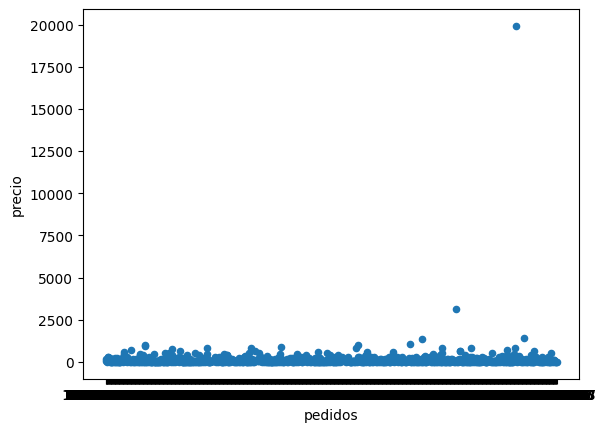

In [21]:
precio_por_pedido=pedidos.groupby('transactionId').agg({'revenue':'sum'}).reset_index()
precio_por_pedido.columns = ['pedidos', 'precio']  # Renombrar para claridad
precio_por_pedido.plot(kind='scatter', x='pedidos', y='precio')
plt.show()

<div class="alert alert-block alert-success">
<b>Acierto o Fortaleza</b> <a class="tocSkip"></a><br>
En las celdas [21]-[22] identificaste outliers de precio por pedido con P95 y P99. Buen enfoque.
</div>

**Conclusion:**

Se ve claramente en el grafico anterior que hay un dato anormal que esta alterando a los demas datos, provocando que la grafica no sea muy precisa.

**8. Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.**

In [22]:
print("Percentiles 95/99:",np.percentile(precio_por_pedido['precio'], [95, 99]))

Percentiles 95/99: [414.275 830.3  ]



**Conclusion:**

Menos del 5% hacen una compra de mas de 414.2 y menos del 1% hace una compra de 830.3, por lo que se puede decir que los pedidos de mas de 415 son datos anormales.


**9. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.**

In [23]:
tasa_conversion_A=relacion_pedidos_visitas.query('group=="A"')['tasa de conversion']
tasa_conversion_B=relacion_pedidos_visitas.query('group=="B"')['tasa de conversion']

alpha = .05 #nivel de significación

results = st.mannwhitneyu(tasa_conversion_A, tasa_conversion_B)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados")
else:
    print("No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados")

p-value:  0.05375707890473213
No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados



**Conclusion:**

Podemos concluir que aunque haya una diferencia en la tasa de conversion entre los grupos, no alcanza a marcar una diferencia estadistacamente significativa.

Como observacion los resultados estan muy cerrados, todo influye de que valor de nivel de significancia consideres, si consideras un valor de 0.05 los resultados seran que no hay diferencias y si consideras un valor de 0.06 los resultados seran que si hay diferencia.



**10. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.**

In [24]:

tamaño_promedio_A=pedidos.query('group=="A"')['revenue']
tamaño_promedio_B=pedidos.query('group=="B"')['revenue']

alpha = .05 #nivel de significación

#para comparar si el tamaño promedio del grupo A es menor que el de grupo B
results = st.mannwhitneyu(tamaño_promedio_A, tamaño_promedio_B,True, 'less')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados")
else:

    print("No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados")


p-value:  0.5689678091666772
No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados



**Conclusion:**

Claramente podemos ver que no hubo una diferencia significativa.


In [25]:
# Se filtro usuarios con menos de 2 pedidos
usuarios_normales = pedidos_por_usuario[pedidos_por_usuario['num_pedidos'] <= 1]['usuario']
# Ahora se filtro los pedidos con menos de de 415
pedidos_filtrados = pedidos[(pedidos['visitorId'].isin(usuarios_normales)) & 
    (pedidos['revenue'] <= 414.275)] 

print(f"Pedidos originales: {len(pedidos)}")
print(f"Pedidos eliminados: {len(pedidos) - len(pedidos_filtrados)}")
print(f"Pedidos filtrados: {len(pedidos_filtrados)}")
pedidos_filtrados

Pedidos originales: 1016
Pedidos eliminados: 129
Pedidos filtrados: 887


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [25], el filtrado de usuarios (por número de pedidos) y de pedidos (por precio) está bien documentado: reportaste originales, eliminados y filtrados. Esa trazabilidad es excelente, porque cualquier lector puede reproducir el recorte y entender su impacto inmediato en el tamaño muestral. Mantener este hábito da mucha confianza en el proceso analítico.
</div>

In [26]:
# Calculo de la tasa de conversión con los datos filtrados
pedidos_por_dia_filtrados = pedidos_filtrados.groupby(['date', 'group'])['visitorId'].count()
pedidos_por_dia_filtrados = pedidos_por_dia_filtrados.reset_index()
pedidos_por_dia_filtrados.columns = ['date', 'group', 'pedidos']
relacion_pedidos_visitas_filtrados = visitas.merge(pedidos_por_dia_filtrados, on=['date', 'group'], how='left')

relacion_pedidos_visitas_filtrados['tasa de conversion']= (relacion_pedidos_visitas_filtrados['pedidos']/relacion_pedidos_visitas_filtrados['visits'])*100
relacion_pedidos_visitas_filtrados


,date,group,visits,pedidos,tasa de conversion
0,2019-08-01,A,719,13,1.808067
1,2019-08-02,A,619,15,2.423263
2,2019-08-03,A,507,24,4.733728
3,2019-08-04,A,717,10,1.394700
4,2019-08-05,A,756,20,2.645503
...,...,...,...,...,...
57,2019-08-27,B,720,9,1.250000
58,2019-08-28,B,654,20,3.058104
59,2019-08-29,B,531,14,2.636535
60,2019-08-30,B,490,18,3.673469


**11. Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.**

In [27]:
tasa_conversion_A_filtrado=relacion_pedidos_visitas_filtrados.query('group=="A"')['tasa de conversion']
tasa_conversion_B_filtrado=relacion_pedidos_visitas_filtrados.query('group=="B"')['tasa de conversion']

alpha = .05 #nivel de significación

results = st.mannwhitneyu(tasa_conversion_A_filtrado, tasa_conversion_B_filtrado)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados")
else:
    print("No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados")

p-value:  0.043349564671668755
Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados


<div class="alert alert-block alert-warning">
<b>Oportunidad de mejora</b> <a class="tocSkip"></a><br>
Tras filtrar (celda [27]) la conversión resulta significativa. Es un hallazgo interesante, pero conviene verificar que el resultado no dependa solo del umbral elegido. Dos ideas sencillas: 1) repetir el test con compradores únicos y un test de proporciones; 2) probar cortes alternativos (p. ej., P97 o P99) para ver estabilidad. Si el resultado se mantiene, la conclusión será más sólida y defendible.
</div>


**Conclusion:**

En este caso el resultado fue diferente, eliminando los usuarios y los pedidos anomalos la misma prueba que se hizo con la tasa de conversion resulto que si hay diferencia entre los grupos.



**12. Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.**

In [28]:
tamaño_promedio_A_filtrado=pedidos_filtrados.query('group=="A"')['revenue']
tamaño_promedio_B_filtrado=pedidos_filtrados.query('group=="B"')['revenue']

alpha = .05 #nivel de significación

#para comparar si el tamaño promedio del grupo A es menor que el de grupo B
results = st.mannwhitneyu(tamaño_promedio_A_filtrado, tamaño_promedio_B_filtrado,True, 'less')

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
    print("Hipótesis nula rechazada: existen diferencias significativas entre las distribuciones de los dos grupos comparados")
else:

    print("No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados")


p-value:  0.6145067339752425
No se rechazó la hipótesis nula: no es posible concluir que hay diferencias significativas entre los grupos comparados


<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
En la celda [28], comprobaste que el resultado del tamaño de pedido se mantiene tanto con datos brutos como filtrados. Esa consistencia es una buena señal: sugiere que la ausencia de diferencia en AOV no depende de los outliers. Como paso adicional, podrías reportar intervalos de confianza (por ejemplo, con bootstrap) para mostrar el rango plausible de la diferencia, lo que redondea una interpretación clara para negocio.
</div>

**Conclusion:**

Con la prueba de los tamaños promedio de pedido no hubo cambios, con los datos brutos o con los datos filtrados dio el mismo resultado, no hay diferencia significativa.


**13. Toma una decisión basada en los resultados de la prueba. Las decisiones posibles son: 1. Parar la prueba, considerar a uno de los grupos como líder. 2. Parar la prueba, concluir que no hay diferencia entre los grupos. 3. Continuar la prueba.**

Para este punto hay que considerar dos cosas:

    1. Si nos interesa mas el marketing tenemos que considerar los datos filtrados ya que con estos datos si nos dio como resultado que los usuarios tienen una tasa de conversion significativa, y por lo tanto podemos decidir parar la prueba, considerar a uno de los grupos como líder.
    
    2. Si nos interesa mas las ventas cualquiera de los dos datos (brutos o filtrados) el resultado sera lo mismo, por lo tanto podemos decidir parar la prueba, concluir que no hay diferencia entre los grupos.

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Edgar! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Organización limpia de librerías y alias estándar (celda [1]).<br>
• Lectura de datos cuidando separadores y formatos (celda [2]).<br>
• Conversión de tipos pertinente, especialmente fechas e IDs (celda [4]).<br>
• Detección y eliminación de visitantes en ambos grupos, evitando contaminación (celdas [5]-[6]).<br>
• Verificación consistente del estado de los DataFrames con <code>info()</code> (celdas [3], [4], [8]).<br>
• Construcción clara de los frameworks ICE y RICE, con ranking ordenado (celdas [10]-[12]).<br>
• Integración de visitas y pedidos para obtener métricas diarias (celda [18]).<br>
• Identificación de outliers mediante percentiles 95/99 de pedidos y precios (celdas [20], [22]).<br>
• Uso de Mann–Whitney para comparar tamaños de pedido, apropiado para distribuciones no normales (celdas [24], [28]).<br>
• Repetición del análisis con datos filtrados y contraste contra datos brutos, mostrando criterio de robustez (celdas [25]-[28]).<br>
• Reporte transparente del impacto del filtrado en el tamaño muestral (celda [25]).<br>
• Conclusiones cautas basadas en p-values y nivel alfa declarado (celdas [23], [24], [27], [28]).<br>
• Gráficos que, aunque mejorables, ya ofrecen una primera lectura de tendencias (celdas [15]-[18], [19], [21]).<br>
• Observación atenta de anomalías temporales en las tasas de conversión (comentario en torno a [18]).<br>
• Estructura del notebook por partes (hipótesis y test A/B), facilitando el seguimiento del lector.<br>
<br>
Con estos aciertos, estás muy cerca de una versión excelente. Afinando los puntos señalados (especialmente métricas acumuladas y pruebas específicas para proporciones), tus conclusiones quedarán aún más sólidas. ¡Felicidades!
</div>